In [ ]:
# notebook for training teacher model on DFCI PHI to predict RECIST progression and response annotations

In [1]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
reports = pd.read_csv('/mnt/d/Dropbox (Partners HealthCare)/profile_3-2023/derived_data/labeled_imaging_prissmm.csv')

In [3]:
# define progression to include annotations of mixed response
reports['progression'] = np.where(reports.class_status==3,1,reports.progression)

In [4]:

reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37274 entries, 0 to 37273
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0.1              37274 non-null  int64  
 1   dfci_mrn                  37274 non-null  float64
 2   cancer_type               37274 non-null  object 
 3   image_scan_type           37274 non-null  float64
 4   date                      37274 non-null  object 
 5   head_imaged               37274 non-null  float64
 6   neck_imaged               37274 non-null  float64
 7   spine_imaged              37274 non-null  float64
 8   chest_imaged              37274 non-null  float64
 9   abdomen_imaged            37274 non-null  float64
 10  pelvis_imaged             37274 non-null  float64
 11  any_cancer                37274 non-null  int64  
 12  progression               37274 non-null  int64  
 13  response                  37274 non-null  int64  
 14  class_

In [5]:
reports.image_scan_type.value_counts()

1.0     22677
3.0      7613
7.0      3405
5.0      2889
11.0      690
Name: image_scan_type, dtype: int64

In [6]:
check_distribution = reports[reports.split=='train']

In [7]:
check_distribution.cancer_type.value_counts()/check_distribution.shape[0]

nsclc_phase2_existing    0.266649
breast                   0.167974
crc                      0.167810
prostate                 0.143314
pancreas                 0.087498
bladder                  0.084630
rcc_barkouny             0.082124
Name: cancer_type, dtype: float64

In [8]:
check_distribution.class_status.value_counts()/check_distribution.shape[0]

0.0    0.445437
4.0    0.216768
2.0    0.153402
5.0    0.104147
1.0    0.062475
3.0    0.017440
Name: class_status, dtype: float64

In [ ]:
to_train = reports[['dfci_mrn','text','split','any_cancer','progression','response','brain_met','bone_met','adrenal_met','liver_met','lung_met','node_met','peritoneal_met']]
to_train['text'] = to_train.text.str.lower()


In [10]:
training = to_train[to_train.split=='train']
#training['length'] = training.text.str.count(' ')

In [12]:
training.shape[0]

30332

In [13]:
training.dfci_mrn.nunique()

2609

In [14]:
validation = to_train[to_train.split=='validation']
#validation['length'] = validation.text.str.count(' ')

In [15]:
test = to_train[to_train.split=='test']


In [16]:
from torch.utils import data

class LabeledDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset.copy()
        self.indices = self.data.index.unique()
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', truncation_side='left')        
        
        
    def __len__(self):
        # how many notes in the dataset
        return len(self.indices)
    
    def __getitem__(self, index):
        # get data for notes corresponding to indices passed
        this_index = self.indices[index]
        pand = self.data.loc[this_index, :]
    
        encoded = self.tokenizer(pand['text'], padding='max_length', truncation=True)

        x_text_tensor = torch.tensor(encoded.input_ids, dtype=torch.long)
        x_attention_mask = torch.tensor(encoded.attention_mask, dtype=torch.long)
        
        y_any_cancer = torch.tensor(pand.any_cancer, dtype=torch.float32)
        y_response = torch.tensor(pand.response, dtype=torch.float32)
        y_progression = torch.tensor(pand.progression, dtype=torch.float32)
        
        y_brain_met = torch.tensor(pand.brain_met, dtype=torch.float32)
        y_bone_met = torch.tensor(pand.bone_met, dtype=torch.float32)
        y_adrenal_met = torch.tensor(pand.adrenal_met, dtype=torch.float32)
        y_liver_met = torch.tensor(pand.liver_met, dtype=torch.float32)
        y_lung_met = torch.tensor(pand.lung_met, dtype=torch.float32)
        y_node_met = torch.tensor(pand.node_met,  dtype=torch.float32)
        y_peritoneal_met = torch.tensor(pand.peritoneal_met, dtype=torch.float32)

        return x_text_tensor, x_attention_mask, y_any_cancer, y_response, y_progression, y_brain_met, y_bone_met, y_adrenal_met, y_liver_met, y_lung_met, y_node_met, y_peritoneal_met
        
        

In [18]:

from transformers import AutoModel



from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, Dropout, Module, Sequential, ReLU

   
class LabeledModel(nn.Module):

    def __init__(self):
        super(LabeledModel, self).__init__()
        
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        
        self.any_cancer_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.response_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.progression_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.brain_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.bone_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.adrenal_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.liver_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.lung_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.node_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))
        self.peritoneal_head = Sequential(Linear(768, 128), ReLU(), Linear(128,1))

        
    def forward(self, x_text_tensor, x_attention_mask):
        # x should be tuple of input IDs, then attention mask
        
        main = self.bert(x_text_tensor, x_attention_mask)
        main = main.last_hidden_state[:,0,:].squeeze(1)

                                          
        any_cancer_out = self.any_cancer_head(main)
        response_out = self.response_head(main)
        progression_out = self.progression_head(main)
        brain_out = self.brain_head(main)
        bone_out = self.bone_head(main)
        adrenal_out = self.adrenal_head(main)
        liver_out = self.liver_head(main)
        lung_out = self.lung_head(main)
        node_out = self.node_head(main)
        peritoneum_out = self.peritoneal_head(main)


        
        return any_cancer_out, response_out, progression_out, brain_out, bone_out, adrenal_out, liver_out, lung_out, node_out, peritoneum_out
        




In [22]:
# train loop
from transformers import get_scheduler
from torch.optim import AdamW, Adam
#, get_linear_schedule_with_warmup


def train_model(model, num_epochs, trainloader, validloader=None, device='cuda'):
    
    

    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = num_epochs * len(trainloader)
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    model.to(device)
    
    for epoch in range(num_epochs):  
        running_train_losses = [0.0 for i in range(10)]
        mean_train_losses = [0.0 for i in range(10)]
        
        running_valid_losses = [0.0 for i in range(10)]
        mean_valid_losses = [0.0 for i in range(10)]

        num_train_batches = len(trainloader)
                
        model.train()
        
        for i, batch in enumerate(trainloader, 0):
            input_ids = batch[0].to(device)
            input_masks = batch[1].to(device)
            
            optimizer.zero_grad()
            
            outputs_true = [x.to(device) for x in batch[2:]]
            
            outputs_pred = model(input_ids, input_masks)
            
           
            losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), outputs_true[x]) for x in range(10)]
            
            total_loss = 0.0
            for j in range(10):
                total_loss = total_loss + losses[j]

                
            total_loss.backward()
            optimizer.step()
            lr_scheduler.step()
            
            
            for j in range(10):
                running_train_losses[j] += losses[j].detach().cpu().numpy()
                mean_train_losses[j] = running_train_losses[j] / (i+1)
                
            print('Training Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ' this_loss:' + str(total_loss.detach().cpu().numpy()) +', train losses: ' + str([str(x) + ': ' + str(mean_train_losses[x]) + ", " for x in range(10)]), end='\r', flush=True)
        
        print('\n')
        # eval on valid
        
        if validloader is not None:
            num_valid_batches = len(validloader)
            model.eval()
            
            for i, batch in enumerate(validloader, 0):
                input_ids = batch[0].to(device)
                input_masks = batch[1].to(device)


                outputs_true = [x.to(device) for x in batch[2:]]

                outputs_pred = model(input_ids, input_masks)

                losses = [F.binary_cross_entropy_with_logits(outputs_pred[x].squeeze(1), outputs_true[x]) for x in range(10)]

                total_loss = 0.0
                for j in range(10):
                    total_loss = total_loss + losses[j]
                


                for j in range(10):
                    running_valid_losses[j] += losses[j].detach().cpu().numpy()

            
            for j in range(10):
                mean_valid_losses[j] = running_valid_losses[j] / (i+1)
            

            
            print('Validation Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_valid_batches) + ', valid losses: ' + str([str(x) + ': ' + str(mean_valid_losses[x]) + ", " for x in range(10)]), end='\r', flush=True)
            print('\n')

    

In [23]:
# actual training code, commented out after model was trained

# training_small = training.sample(10)
# validation_small = validation.sample(10)

# themodel = LabeledModel().to('cuda')
# trainloader = data.DataLoader(LabeledDataset(training.reset_index(drop=True)), batch_size=16, num_workers=8, shuffle=True)
# validloader = data.DataLoader(LabeledDataset(validation.reset_index(drop=True)), batch_size=16, num_workers=8, shuffle=True)
# train_model(themodel,3, trainloader, validloader)

In [24]:
# torch.save(themodel.state_dict(), './pan_prissmm_full_imaging_bert.pt')

In [25]:
# write out actual validation dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('./pan_prissmm_full_imaging_bert.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(validation), batch_size=16, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(10)]
output_prediction_lists = [[] for x in range(10)]
for batch in no_shuffle_valid_dataset:
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(10):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_validation = validation.copy()
for x in range(10):
    output_validation['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



In [26]:
from sklearn.metrics import roc_auc_score


In [27]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(10)]

0.9641739987904319
0.9658665717767068
0.9582305281408376
0.9896929478308519
0.9873038068314233
0.9854578433825368
0.9851000898396989
0.9684762348555452
0.9753968201783224
0.982280179272217


[None, None, None, None, None, None, None, None, None, None]

In [29]:
import seaborn as sns

/tmp/ipykernel_5431/475399193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output_validation.outcome_1_logit)


<Axes: xlabel='outcome_1_logit', ylabel='Density'>

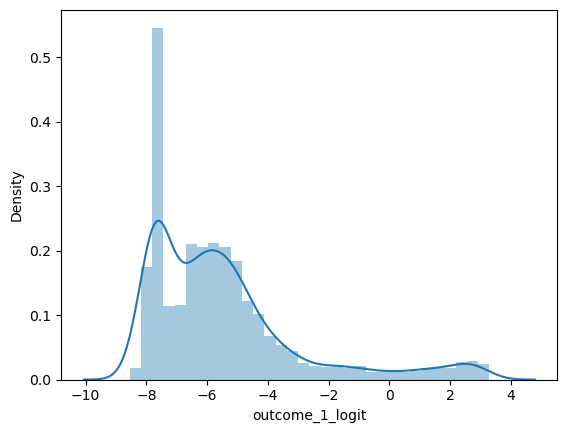

In [30]:
sns.distplot(output_validation.outcome_1_logit)

In [31]:
# write out actual test dataset
themodel = LabeledModel()
themodel.load_state_dict(torch.load('./pan_prissmm_full_imaging_bert.pt'))
themodel.to('cuda')

themodel.eval()

no_shuffle_valid_dataset = data.DataLoader(LabeledDataset(test), batch_size=16, shuffle=False, num_workers=0)

output_true_lists = [[] for x in range(10)]
output_prediction_lists = [[] for x in range(10)]
for batch in no_shuffle_valid_dataset:
    #thisframe = pd.DataFrame()
    x_text_ids = batch[0].to('cuda')
    x_attention_mask = batch[1].to('cuda')
    with torch.no_grad():
        predictions = themodel(x_text_ids, x_attention_mask)
    for j in range(10):
        output_true_lists[j].append(batch[2+j].detach().cpu().numpy())
        output_prediction_lists[j].append(predictions[j].detach().cpu().numpy())

output_true_lists = [np.concatenate(x) for x in output_true_lists]        
output_prediction_lists = [np.concatenate(x) for x in output_prediction_lists]


output_test = test.copy()
for x in range(10):
    output_test['outcome_' + str(x) + '_logit'] = output_prediction_lists[x]



In [32]:
from sklearn.metrics import roc_auc_score


In [33]:
[print(roc_auc_score(output_true_lists[x], output_prediction_lists[x])) for x in range(10)]

0.9743241398235375
0.9741017978835665
0.9555354364786938
0.9925895684409616
0.9894491341991342
0.9878546905828924
0.9866442773804871
0.9792392097045892
0.974277370846152
0.9881377129401502


[None, None, None, None, None, None, None, None, None, None]

In [57]:
#output_test.to_csv('./data/dfci_phi_imaging_eval_on_test.csv')